In [13]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import csv

In [14]:
df = pd.read_csv('elnino_clean_final_1997.csv')
print(df['Sea_Surface_Temp'])
print(df)

0        22.73
1        24.91
2        25.93
3        29.52
4        29.92
         ...  
14771    30.80
14772    30.08
14773    29.69
14774    26.74
14775    26.74
Name: Sea_Surface_Temp, Length: 14776, dtype: float64
         Date  Latitude  Longitude  Zonal_Winds  Meridional_Winds  Humidity  \
0      970101      0.07    -110.01         -3.1               1.4      89.6   
1      970101      0.01    -140.02         -7.4              -0.6      80.4   
2      970101     -0.01    -155.02         -6.8              -1.3      79.7   
3      970101      0.00     156.15          7.3              -0.9      79.9   
4      970101     -0.04     165.11          2.4               0.1      78.9   
...       ...       ...        ...          ...               ...       ...   
14771  971231     -8.28    -154.96         -1.9              -0.2      72.7   
14772  971231     -8.03     164.81          5.3              -4.2      87.6   
14773  971231     -7.98    -170.02          3.5               3.3     

In [23]:
Z = pd.DataFrame(df['Sea_Surface_Temp'])
Z['Air_Temp'] = pd.Series(df['Air_Temp'])
mod = smf.quantreg("Sea_Surface_Temp ~  Air_Temp", Z)
res = mod.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:       Sea_Surface_Temp   Pseudo R-squared:               0.5057
Model:                       QuantReg   Bandwidth:                      0.1139
Method:                 Least Squares   Sparsity:                        1.365
Date:                Wed, 14 Jun 2023   No. Observations:                14776
Time:                        17:54:20   Df Residuals:                    14774
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6787      0.133      5.117      0.000       0.419       0.939
Air_Temp       1.0025      0.005    208.236      0.000       0.993       1.012


In [16]:
quantiles = np.arange(0.05, 0.96, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["Air_Temp"]] + res.conf_int().loc[
        "Air_Temp"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("Sea_Surface_Temp ~ Air_Temp", Z).fit()
ols_ci = ols.conf_int().loc["Air_Temp"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Air_Temp"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

      q          a         b        lb        ub
0  0.05  -0.947989  1.037529  1.025586  1.049473
1  0.15  -0.683234  1.035715  1.027012  1.044418
2  0.25  -0.285789  1.026316  1.018465  1.034167
3  0.35   0.021435  1.019480  1.011272  1.027689
4  0.45   0.469617  1.007812  0.998727  1.016898
5  0.55   1.091694  0.990195  0.979927  1.000463
6  0.65   2.294003  0.952941  0.941804  0.964078
7  0.75   5.042589  0.862205  0.849095  0.875316
8  0.85   9.915030  0.697297  0.685188  0.709406
9  0.95  14.917940  0.530613  0.519819  0.541407
{'a': 2.2258855675266522, 'b': 0.9507832475277344, 'lb': 0.9423503030416973, 'ub': 0.9592161920137714}


Text(0, 0.5, 'Sea_Surface_Temp')

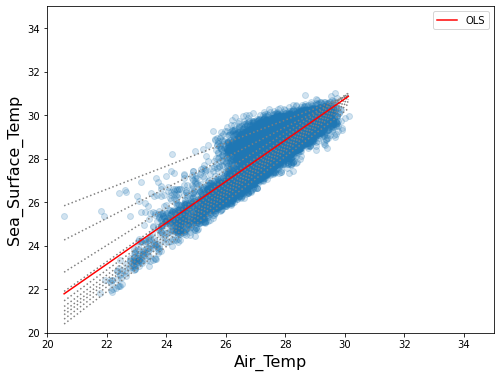

In [17]:
x = np.arange(Z['Air_Temp'].min(), Z['Air_Temp'].max(), 0.01)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(Z['Air_Temp'], Z['Sea_Surface_Temp'], alpha=0.2)
ax.set_xlim((20, 35))
ax.set_ylim((20, 35))
legend = ax.legend()
ax.set_xlabel("Air_Temp", fontsize=16)
ax.set_ylabel("Sea_Surface_Temp", fontsize=16)

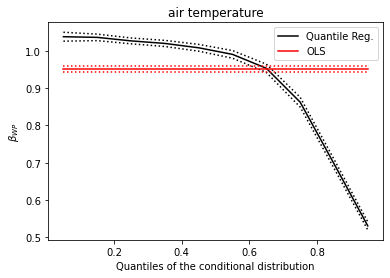

In [19]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel(r"$\beta_{WP}$")
plt.xlabel("Quantiles of the conditional distribution")
plt.legend()
plt.title('air temperature')
plt.savefig('single_variable_airtemp.png', dpi=800)
plt.show()

In [25]:
X = df
X = X.drop('Date', axis = 1)
X = X.drop('Zonal_Winds', axis = 1)
X = X.drop('Meridional_Winds', axis = 1)
X = X.drop('Sea_Surface_Temp', axis = 1)
X

,Latitude,Longitude,Humidity,Air_Temp
0,0.07,-110.01,89.6,22.66
1,0.01,-140.02,80.4,24.47
2,-0.01,-155.02,79.7,25.60
3,0.00,156.15,79.9,27.56
4,-0.04,165.11,78.9,28.07
...,...,...,...,...
14771,-8.28,-154.96,72.7,29.74
14772,-8.03,164.81,87.6,28.78
14773,-7.98,-170.02,81.2,28.66
14774,-8.00,-95.10,81.5,26.09


In [40]:
mod = smf.quantreg("Air_Temp ~ Latitude + Longitude + Humidity", X)
res = mod.fit(q=0.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:               Air_Temp   Pseudo R-squared:               0.1295
Model:                       QuantReg   Bandwidth:                      0.1694
Method:                 Least Squares   Sparsity:                        2.095
Date:                Wed, 14 Jun 2023   No. Observations:                14776
Time:                        17:58:10   Df Residuals:                    14772
                                        Df Model:                            3
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.7507      0.154    232.214      0.000      35.449      36.052
Latitude       0.0315      0.002     17.083      0.000       0.028       0.035
Longitude      0.0015   6.62e-05     22.257      0.000       0.001       0.002
Humidity      -0.0991      0.002    -51.829      0.0

In [41]:
correlation_matrix = X.corr()
print(correlation_matrix)

           Latitude  Longitude  Humidity  Air_Temp
Latitude   1.000000   0.069257  0.324209  0.060725
Longitude  0.069257   1.000000 -0.022102  0.218914
Humidity   0.324209  -0.022102  1.000000 -0.354071
Air_Temp   0.060725   0.218914 -0.354071  1.000000


In [42]:
quantiles = np.arange(0.05, 0.96, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["Latitude"]] + res.conf_int().loc[
        "Latitude"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("Air_Temp ~ Latitude", X).fit()
ols_ci = ols.conf_int().loc["Latitude"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Latitude"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

      q          a         b        lb        ub
0  0.05  35.287666  0.100960  0.089048  0.112872
1  0.15  35.589471  0.073751  0.067372  0.080130
2  0.25  35.931135  0.060821  0.055308  0.066334
3  0.35  35.858883  0.046008  0.041665  0.050352
4  0.45  35.742524  0.036702  0.033041  0.040364
5  0.55  35.640488  0.027634  0.024104  0.031164
6  0.65  35.566549  0.017573  0.014360  0.020787
7  0.75  35.338082  0.005281  0.002260  0.008303
8  0.85  34.836602 -0.011172 -0.014192 -0.008151
9  0.95  33.839336 -0.029889 -0.033171 -0.026607
{'a': 27.522085496165953, 'b': 0.01429498948524972, 'lb': 0.010505788782566208, 'ub': 0.01808419018793323}


Text(0, 0.5, 'Air_Temp')

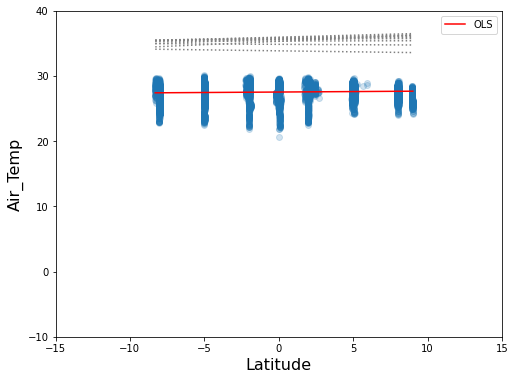

In [43]:
x = np.arange(X['Latitude'].min(), X['Latitude'].max(), 0.01)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(X['Latitude'], X['Air_Temp'], alpha=0.2)
ax.set_xlim((-15, 15))
ax.set_ylim((-10, 40))
legend = ax.legend()
ax.set_xlabel("Latitude", fontsize=16)
ax.set_ylabel("Air_Temp", fontsize=16)

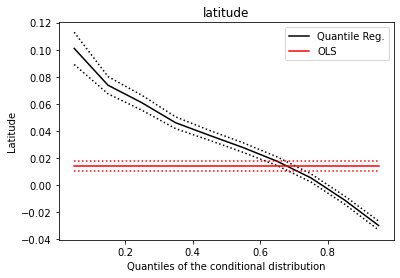

In [44]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel("Latitude")
plt.xlabel("Quantiles of the conditional distribution")
plt.title("latitude")
plt.legend()
plt.savefig('multi_variable_latitude.png', dpi=800)
plt.show()

In [45]:
quantiles = np.arange(0.05, 0.96, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["Longitude"]] + res.conf_int().loc[
        "Longitude"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("Air_Temp ~ Longitude", X).fit()
ols_ci = ols.conf_int().loc["Longitude"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Longitude"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

      q          a         b        lb        ub
0  0.05  35.287666  0.005245  0.004963  0.005528
1  0.15  35.589471  0.003415  0.003239  0.003591
2  0.25  35.931135  0.002469  0.002304  0.002635
3  0.35  35.858883  0.001926  0.001785  0.002067
4  0.45  35.742524  0.001613  0.001486  0.001740
5  0.55  35.640488  0.001333  0.001202  0.001463
6  0.65  35.566549  0.001101  0.000976  0.001227
7  0.75  35.338082  0.000923  0.000800  0.001046
8  0.85  34.836602  0.000775  0.000644  0.000906
9  0.95  33.839336  0.000792  0.000638  0.000946
{'a': 27.658154494078392, 'b': 0.001955191449355974, 'lb': 0.001814656092559248, 'ub': 0.0020957268061527}


Text(0, 0.5, 'Air_Temp')

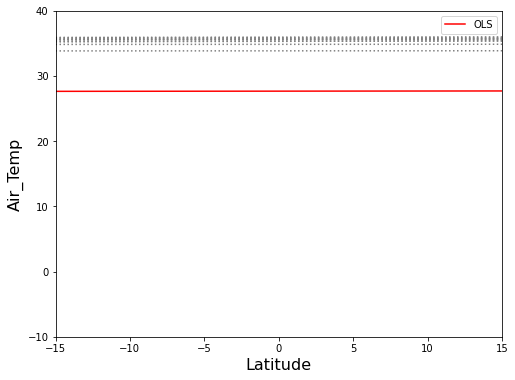

In [46]:
x = np.arange(X['Longitude'].min(), X['Longitude'].max(), 0.01)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(X['Longitude'], X['Air_Temp'], alpha=0.2)
ax.set_xlim((-15, 15))
ax.set_ylim((-10, 40))
legend = ax.legend()
ax.set_xlabel("Latitude", fontsize=16)
ax.set_ylabel("Air_Temp", fontsize=16)

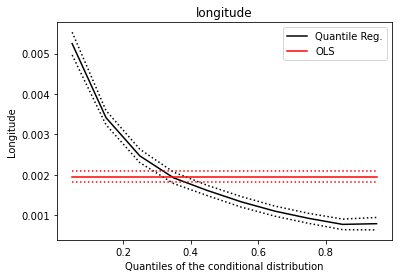

In [47]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel("Longitude")
plt.xlabel("Quantiles of the conditional distribution")
plt.title('longitude')
plt.legend()
plt.savefig('multi_variable_longitude.png', dpi=800)
plt.show()

In [48]:
quantiles = np.arange(0.05, 0.96, 0.1)


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params["Humidity"]] + res.conf_int().loc[
        "Humidity"
    ].tolist()


models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b", "lb", "ub"])

ols = smf.ols("Air_Temp ~ Humidity", X).fit()
ols_ci = ols.conf_int().loc["Humidity"].tolist()
ols = dict(
    a=ols.params["Intercept"], b=ols.params["Humidity"], lb=ols_ci[0], ub=ols_ci[1]
)

print(models)
print(ols)

      q          a         b        lb        ub
0  0.05  35.287666 -0.116068 -0.128694 -0.103442
1  0.15  35.589471 -0.109917 -0.116268 -0.103567
2  0.25  35.931135 -0.109241 -0.114816 -0.103666
3  0.35  35.858883 -0.104592 -0.109065 -0.100119
4  0.45  35.742524 -0.100270 -0.104068 -0.096471
5  0.55  35.640488 -0.096414 -0.100060 -0.092767
6  0.65  35.566549 -0.092987 -0.096253 -0.089721
7  0.75  35.338082 -0.087403 -0.090378 -0.084427
8  0.85  34.836602 -0.078088 -0.080920 -0.075257
9  0.95  33.839336 -0.060941 -0.064038 -0.057843
{'a': 34.503434215158016, 'b': -0.08661450152308982, 'lb': -0.0903038397474525, 'ub': -0.08292516329872714}


Text(0, 0.5, 'Air_Temp')

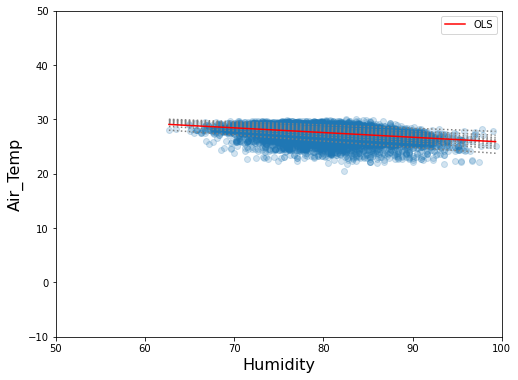

In [49]:
x = np.arange(X['Humidity'].min(), X['Humidity'].max(), 0.01)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

y = get_y(ols["a"], ols["b"])

ax.plot(x, y, color="red", label="OLS")
ax.scatter(X['Humidity'], X['Air_Temp'], alpha=0.2)
ax.set_xlim((50, 100))
ax.set_ylim((-10, 50))
legend = ax.legend()
ax.set_xlabel("Humidity", fontsize=16)
ax.set_ylabel("Air_Temp", fontsize=16)

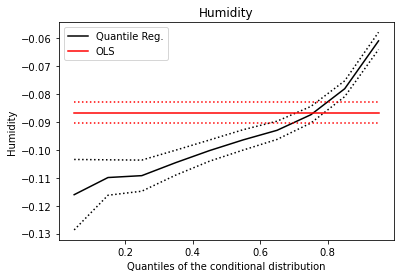

In [50]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color="black", label="Quantile Reg.")
p2 = plt.plot(models.q, models.ub, linestyle="dotted", color="black")
p3 = plt.plot(models.q, models.lb, linestyle="dotted", color="black")
p4 = plt.plot(models.q, [ols["b"]] * n, color="red", label="OLS")
p5 = plt.plot(models.q, [ols["lb"]] * n, linestyle="dotted", color="red")
p6 = plt.plot(models.q, [ols["ub"]] * n, linestyle="dotted", color="red")
plt.ylabel("Humidity")
plt.xlabel("Quantiles of the conditional distribution")
plt.title('Humidity')
plt.legend()
plt.savefig('multi_variable_humidity.png', dpi=800)
plt.show()